In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url: str, fname: Union[pathlib.Path, str] = None, dest: Union[pathlib.Path, str] = None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz to folder `dest`.



In [4]:
doc(untar_data)

In [5]:
path = untar_data(URLs.PETS, dest="data"); path

PosixPath('data/oxford-iiit-pet')

In [6]:
path.ls()

[PosixPath('data/oxford-iiit-pet/models'),
 PosixPath('data/oxford-iiit-pet/image_gen'),
 PosixPath('data/oxford-iiit-pet/annotations'),
 PosixPath('data/oxford-iiit-pet/crappy'),
 PosixPath('data/oxford-iiit-pet/images')]

In [7]:
path_anno = path/"annotations"
path_img = path/"images"

In [8]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('data/oxford-iiit-pet/images/wheaten_terrier_27.jpg'),
 PosixPath('data/oxford-iiit-pet/images/British_Shorthair_90.jpg'),
 PosixPath('data/oxford-iiit-pet/images/english_cocker_spaniel_106.jpg'),
 PosixPath('data/oxford-iiit-pet/images/Birman_37.jpg'),
 PosixPath('data/oxford-iiit-pet/images/beagle_175.jpg')]

In [9]:
np.random.seed(2)
pat = r"/([^/]+)_\d+.jpg$"

In [10]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat,
                                   ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
wheaten_terrier,British_Shorthair,english_cocker_spaniel,wheaten_terrier,miniature_pinscher
Path: data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bombay,Ragdoll,Bombay,pug,Maine_Coon
Path: data/oxford-iiit-pet/images;

Test: None

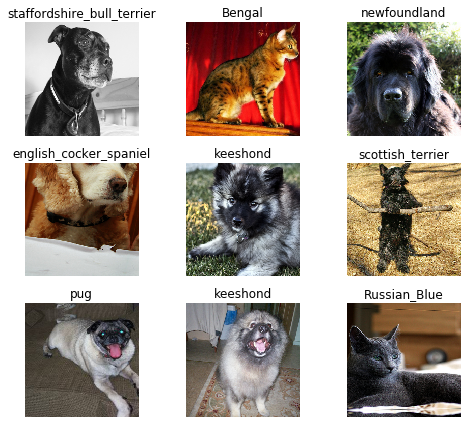

In [11]:
data.show_batch(rows=3, figsize=(7,6))

data.c is the number of classes for classification problems

In [12]:
print(data.classes)
len(data.classes), data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

we will use resnet34

In [13]:
help(cnn_learner)

Help on function cnn_learner in module fastai.vision.learner:

cnn_learner(data: fastai.basic_data.DataBunch, base_arch: Callable, cut: Union[int, Callable] = None, pretrained: bool = True, lin_ftrs: Union[Collection[int], NoneType] = None, ps: Union[float, Collection[float]] = 0.5, custom_head: Union[torch.nn.modules.module.Module, NoneType] = None, split_on: Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType] = None, bn_final: bool = False, init=<function kaiming_normal_ at 0x7f77773cbf80>, concat_pool: bool = True, **kwargs: Any) -> fastai.basic_train.Learner
    Build convnet style learner.



In [14]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [15]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.363475,0.331276,0.108931,07:23
1,0.626245,0.312239,0.100135,07:23
2,0.362643,0.263554,0.088633,07:23
3,0.272432,0.253771,0.092016,07:26


Save our model under a subdirectory in our data folder

In [16]:
learn.path

PosixPath('data/oxford-iiit-pet/images')

In [17]:
learn.save("stage-1")

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

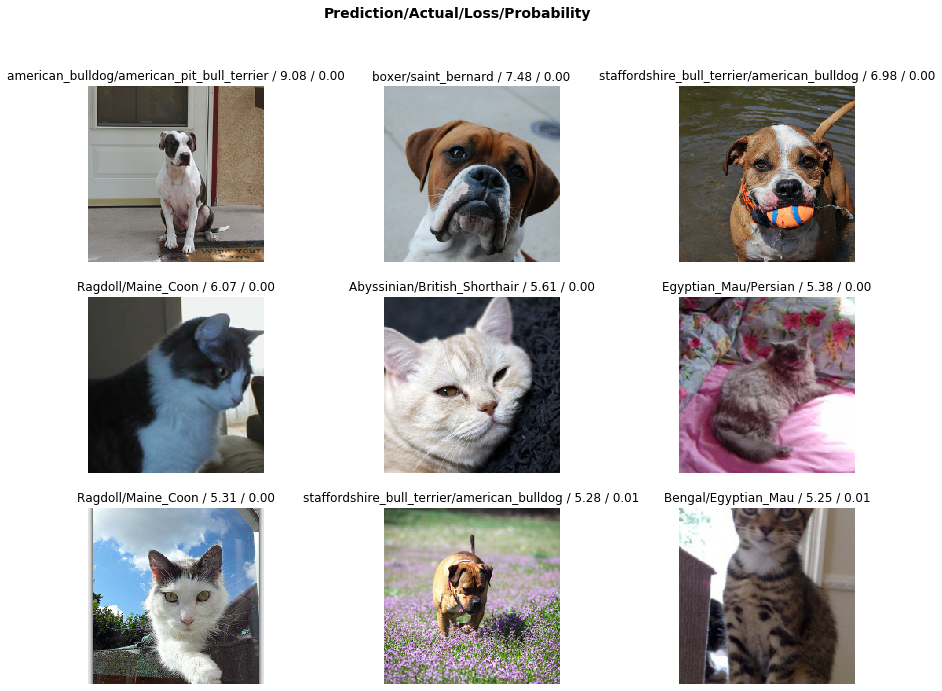

In [19]:
interp.plot_top_losses(9, figsize=(15, 11))

In [20]:
doc(interp.plot_multi_top_losses)

## Make predictions of Elsie 

In [21]:
val = open_image("IMG_20150125_132435.jpg")
an, ind, pre = learn.predict(val)

In [22]:
[(x,y) for y,x in sorted(zip(pre, data.classes), reverse=True)][:5]

[('Sphynx', tensor(0.3165)),
 ('chihuahua', tensor(0.2727)),
 ('miniature_pinscher', tensor(0.1540)),
 ('Abyssinian', tensor(0.1204)),
 ('american_pit_bull_terrier', tensor(0.0793))]

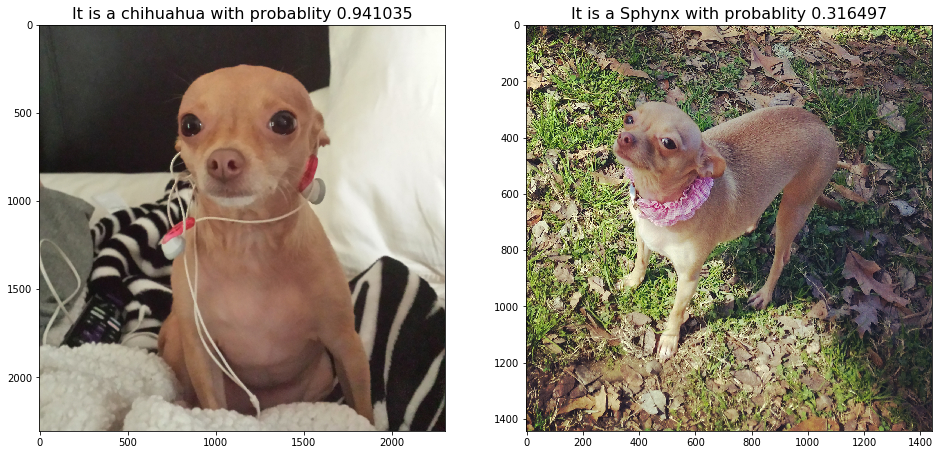

In [23]:
im = ["IMG_20160430_220313.jpg", "IMG_20150125_132435.jpg"]
fig, axes = plt.subplots(1,2,figsize=(16,8))
for i, ax in enumerate(axes.flatten()):
    val = open_image(im[i])
    an, ind, pre = learn.predict(val)
    ax.imshow(val.data.permute(1, 2, 0))
    ax.set_title("It is a %s with probablity %f" % (data.classes[ind], pre[ind]), fontsize=16);

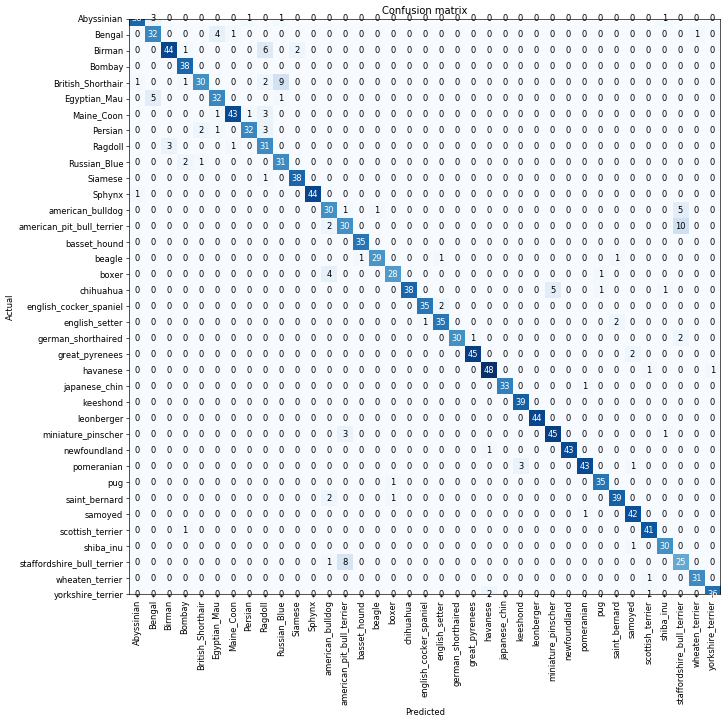

In [24]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('British_Shorthair', 'Russian_Blue', 9),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),
 ('Birman', 'Ragdoll', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('american_bulldog', 'staffordshire_bull_terrier', 5),
 ('chihuahua', 'miniature_pinscher', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('boxer', 'american_bulldog', 4),
 ('Abyssinian', 'Bengal', 3),
 ('Maine_Coon', 'Ragdoll', 3),
 ('Persian', 'Ragdoll', 3),
 ('Ragdoll', 'Birman', 3),
 ('miniature_pinscher', 'american_pit_bull_terrier', 3),
 ('pomeranian', 'keeshond', 3),
 ('Birman', 'Siamese', 2),
 ('British_Shorthair', 'Ragdoll', 2),
 ('Persian', 'British_Shorthair', 2),
 ('Russian_Blue', 'Bombay', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_setter', 'saint_bernard', 2),
 ('german_shorthaired', 'staffordshire_bull_terrier', 2),
 ('great_pyrenees', 'samoyed', 2),
 ('saint_bernard', 'amer

make our model better by fine tunning, we only trained the last layer but we can train the whole model now. A rule of thumb is to do this process train, first layer and train the whole network.

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.639080,0.366291,0.120433,09:39


our model got worse why? Lets get back to our first step.

In [28]:
learn.load("stage-1")

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
wheaten_terrier,British_Shorthair,english_cocker_spaniel,wheaten_terrier,miniature_pinscher
Path: data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bombay,Ragdoll,Bombay,pug,Maine_Coon
Path: data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padd

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


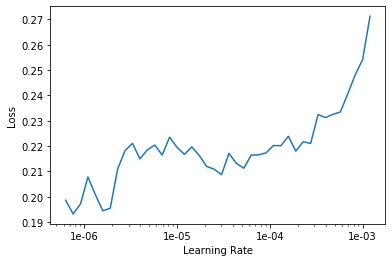

In [30]:
learn.recorder.plot()

distribute different learning rates across the layers from 1e-6 to 1e-4

In [31]:
learn.load("stage-1")
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-8, 1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.225412,0.251393,0.089986,09:41
1,0.224145,0.251959,0.087957,09:43


In [32]:
learn.save("stage-2")

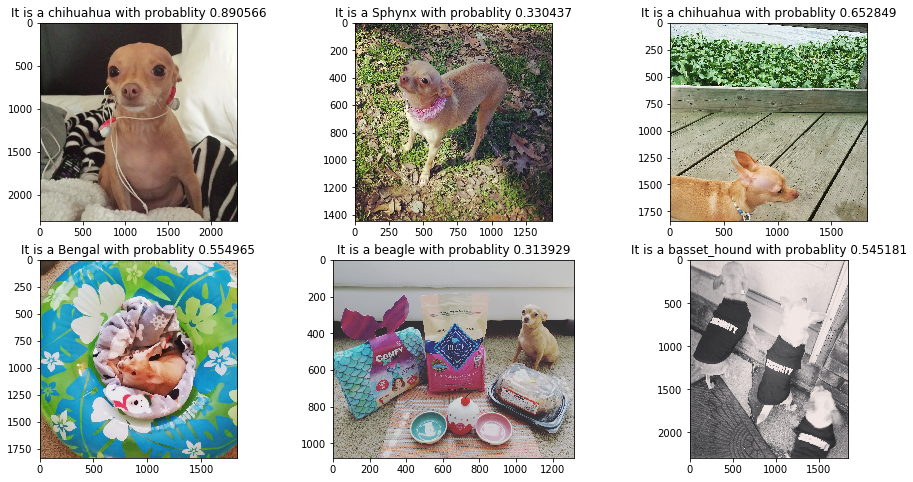

In [33]:
im = ["IMG_20160430_220313.jpg", "IMG_20150125_132435.jpg",
      "IMG_20150516_161347.jpg", "IMG_20160612_181807.jpg",
      "IMG_20170609_232522_611.jpg", "IMG_20160827_193600.jpg"]

fig, axes = plt.subplots(2,3,figsize=(16,8))
for i, ax in enumerate(axes.flatten()):
    val = open_image(im[i])
    an, ind, pre = learn.predict(val)
    ax.imshow(val.data.permute(1, 2, 0))
    ax.set_title("It is a %s with probablity %f" % (data.classes[ind], pre[ind]), fontsize=12);